In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.functions import avg, desc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Final Project - BreweryAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 21:14:36 INFO SparkEnv: Registering MapOutputTracker
23/12/13 21:14:36 INFO SparkEnv: Registering BlockManagerMaster
23/12/13 21:14:36 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/13 21:14:36 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
file_path = 'gs://final_project_bucket2/brewery_data_cleaned/brewery_data_cleaned_.csv'
file_type = "csv"

infer_schema = 'true'
first_row_is_header = 'true' 
delimiter = ','


brewery_data = spark.read.format(file_type)\
    .option("inferSchema",infer_schema)\
    .option("header", first_row_is_header) \
    .option("sep", delimiter)\
    .load(file_path)

brewery_data = brewery_data.limit(50000)

In [4]:
brewery_data.show(10)

+--------+-------------------+----------+-------+-----------+-----------------+------------------+------------------+------------------+------------------+----------+-----+----------------+---------------+------------------+------------------+--------------------+-------------------+------------------------+----------------------------+
|Batch_ID|          Brew_Date|Beer_Style|    SKU|   Location|Fermentation_Time|       Temperature|          pH_Level|           Gravity|   Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|       Total_Sales|     Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+--------+-------------------+----------+-------+-----------+-----------------+------------------+------------------+------------------+------------------+----------+-----+----------------+---------------+------------------+------------------+--------------------+-------------------+------------------------+-------------

In [5]:
brewery_data.describe().show()

+-------+-----------------+----------+-------+---------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+----------------+------------------+------------------+------------------+--------------------+-------------------+------------------------+----------------------------+
|summary|         Batch_ID|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|             Gravity|    Alcohol_Content|        Bitterness|            Color|Ingredient_Ratio|   Volume_Produced|       Total_Sales|     Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+-------+-----------------+----------+-------+---------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+----------------+------------------+------------------+-----------------

In [6]:
total_rows = brewery_data.count()
print("Total number of rows:", total_rows)

Total number of rows: 50000


### Beer Style Analysis

In [7]:
# Complex Query: Average Alcohol Content by Beer Style
avg_alcohol_by_style = brewery_data.groupBy("Beer_Style").agg(avg("Alcohol_Content").alias("Average_Alcohol_Content"))
avg_alcohol_by_style.show()

+----------+-----------------------+
|Beer_Style|Average_Alcohol_Content|
+----------+-----------------------+
|Wheat Beer|      5.245709518445702|
|      Sour|     5.2451038122826175|
|       Ale|      5.253115414277691|
|     Stout|      5.246143344126791|
|     Lager|      5.250145035274896|
|   Pilsner|       5.24427915461009|
|       IPA|      5.258580800784985|
|    Porter|      5.253928817764913|
+----------+-----------------------+



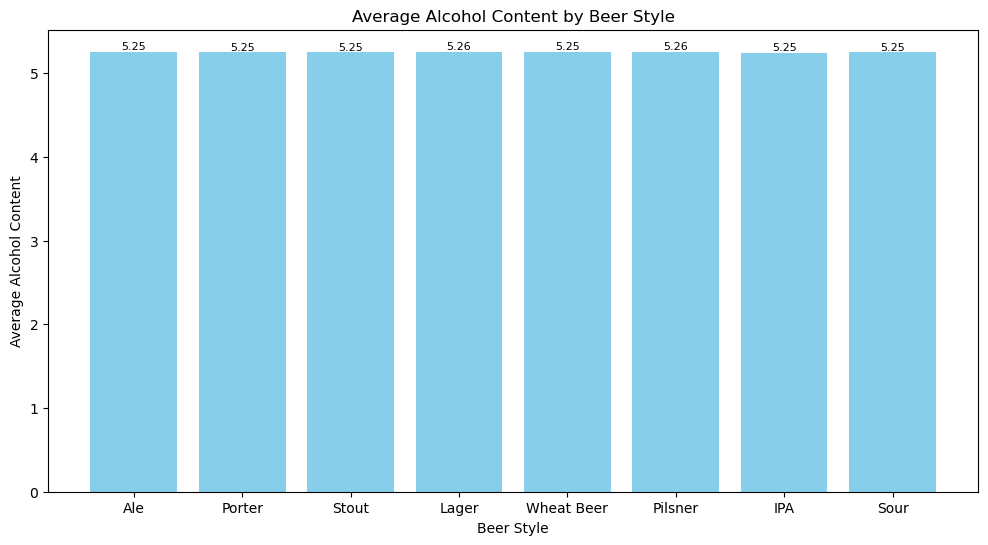

In [8]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for plotting
avg_alcohol_pd = avg_alcohol_by_style.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(avg_alcohol_pd['Beer_Style'], avg_alcohol_pd['Average_Alcohol_Content'], color='skyblue')
plt.title('Average Alcohol Content by Beer Style')
plt.xlabel('Beer Style')
plt.ylabel('Average Alcohol Content')

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

plt.show()

### Quality Score Analysis

+----------+------------------+
|Beer_Style|avg(Quality_Score)|
+----------+------------------+
|Wheat Beer| 8.001329753344521|
|      Sour|  8.00908560188548|
|       Ale| 8.033884306991194|
|     Stout| 7.980341428765183|
|     Lager|7.9956336309066005|
|   Pilsner| 8.000550269864792|
|       IPA| 7.985296283909043|
|    Porter|  7.98813275432802|
+----------+------------------+



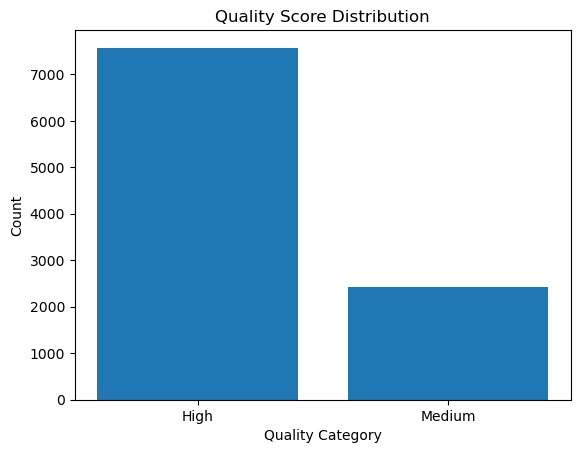

In [9]:
average_quality_per_style = brewery_data.groupBy("Beer_Style").agg({"Quality_Score": "avg"})
average_quality_per_style.show()

brewery_data = brewery_data.withColumn(
    "Quality_Category",
    when(col("Quality_Score") >= 7.0, "High").when((col("Quality_Score") >= 5.0) & (col("Quality_Score") < 7.0), "Medium").otherwise("Low")
)

quality_distribution = brewery_data.groupBy("Quality_Category").count()
average_quality_per_location = brewery_data.groupBy("Location").agg({"Quality_Score": "avg"})
highest_rated_beer = brewery_data.orderBy("Quality_Score", ascending=False).first()

pd_brewery_data = brewery_data.limit(10000).toPandas()

pd_brewery_data['Count'] = 1

import matplotlib.pyplot as plt

quality_distribution = pd_brewery_data.groupby("Quality_Category").agg({'Count': 'sum'}).reset_index()

plt.bar(quality_distribution["Quality_Category"], quality_distribution["Count"])
plt.title("Quality Score Distribution")
plt.xlabel("Quality Category")
plt.ylabel("Count")
plt.show()

### Time Series Analysis

In [10]:
from pyspark.sql.functions import year, month

# Analyze trends over months
monthly_analysis = brewery_data.groupBy(year("Brew_Date").alias("Year"), month("Brew_Date").alias("Month")).agg({"Total_Sales": "sum", "Quality_Score": "avg"})
monthly_analysis.show()

+----+-----+--------------------+------------------+
|Year|Month|    sum(Total_Sales)|avg(Quality_Score)|
+----+-----+--------------------+------------------+
|2020|    1|5.2203063341112053E8| 7.996719089396993|
+----+-----+--------------------+------------------+



### Location Based Analysis

In [11]:
# Analyze metrics based on location
location_analysis = brewery_data.groupBy("Location").agg({"Total_Sales": "sum", "Quality_Score": "avg"})
location_analysis.show()

+---------------+--------------------+------------------+
|       Location|    sum(Total_Sales)|avg(Quality_Score)|
+---------------+--------------------+------------------+
|      Yelahanka|5.3613761789175764E7| 8.006363370276002|
|      Jayanagar| 5.296894077305655E7| 7.977635293362102|
|    Indiranagar| 5.324008315203388E7|7.9997229913043535|
|    Malleswaram| 5.054649416232814E7| 7.984090570149101|
|    Rajajinagar| 5.297740438955347E7| 8.026043910639501|
|     Whitefield| 5.227577083597719E7| 7.994022756876158|
|     HSR Layout| 5.204547881898993E7| 8.018448102165284|
|Electronic City| 5.111250915044211E7| 7.983960074538443|
|   Marathahalli| 5.104601777595729E7| 7.997872135641635|
|    Koramangala|5.2204172563604526E7| 7.978216167608048|
+---------------+--------------------+------------------+



### Correlation Analysis

In [12]:
from pyspark.sql.functions import corr

# Explore correlation between Alcohol_Content and Total_Sales
correlation_analysis = brewery_data.select(corr("Alcohol_Content", "Total_Sales").alias("Alcohol_Sales_Correlation"))
correlation_analysis.show()

+-------------------------+
|Alcohol_Sales_Correlation|
+-------------------------+
|     0.005820258297990337|
+-------------------------+



### Loss Analysis

In [13]:
# Analyze losses during different stages
loss_analysis = brewery_data.selectExpr("Loss_During_Brewing", "Loss_During_Fermentation", "Loss_During_Bottling_Kegging")
loss_analysis.describe().show()


+-------+-------------------+------------------------+----------------------------+
|summary|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+-------+-------------------+------------------------+----------------------------+
|  count|              50000|                   50000|                       50000|
|   mean| 3.0003085728996632|      3.0024055317215197|           2.998934596994121|
| stddev| 1.1549948543459887|      1.1573646887738454|          1.1511467777100304|
|    min| 1.0001083028386546|      1.0001071009299776|           1.000048287778974|
|    max| 4.9998726866696686|       4.999988495603916|           4.999888606354949|
+-------+-------------------+------------------------+----------------------------+



### Ingredient Analysis

In [14]:
# Analyze the impact of ingredient ratios on quality score
ingredient_analysis = brewery_data.groupBy("Ingredient_Ratio").agg({"Quality_Score": "avg"})
ingredient_analysis.show()

+----------------+------------------+
|Ingredient_Ratio|avg(Quality_Score)|
+----------------+------------------+
|     1:0.32:0.16| 8.219218100581768|
|     1:0.39:0.24| 8.090708128628549|
|     1:0.35:0.16| 8.108022616128109|
|     1:0.35:0.15| 8.277151310752902|
|     1:0.46:0.11| 8.163443215020479|
|     1:0.23:0.15| 7.952327158287579|
|     1:0.34:0.16| 7.912641460522047|
|     1:0.45:0.26| 7.769376385377378|
|     1:0.39:0.19|7.8581673092013204|
|     1:0.43:0.17| 7.876742780765365|
|     1:0.27:0.16| 7.980353838150627|
|     1:0.44:0.25| 8.039630431023522|
|     1:0.30:0.24| 7.926859717091982|
|     1:0.24:0.14| 7.924785156106348|
|     1:0.50:0.28| 7.954075408211366|
|     1:0.47:0.12|7.9025281864522645|
|     1:0.31:0.21|7.9505366223926215|
|     1:0.32:0.28| 7.750618005825428|
|     1:0.23:0.16| 7.911398536882175|
|     1:0.34:0.14| 7.922684135005669|
+----------------+------------------+
only showing top 20 rows



### Volume and Sales Analysis

In [15]:
# Analyze the relationship between volume produced and total sales
volume_sales_analysis = brewery_data.groupBy("Volume_Produced").agg({"Total_Sales": "sum"})
volume_sales_analysis.show()


+---------------+------------------+
|Volume_Produced|  sum(Total_Sales)|
+---------------+------------------+
|           3464| 68127.69569429406|
|           4486| 166093.0468152832|
|           3399|149553.18191196953|
|           4043|144625.56765274194|
|           4606|134077.77208755928|
|           1070|63498.717416157146|
|           2177|227268.73725857833|
|           4898|125263.22128828289|
|           4471|181244.28789626766|
|           4374|136831.72181562235|
|           4816| 199893.3272591633|
|           1398|123608.14692905058|
|           2479|106901.04992659527|
|           3644|139208.75023250017|
|           1663|111289.55465464051|
|           1127|156515.72870468945|
|           2393| 95955.45053866165|
|            884| 76875.59580143356|
|           1678|108750.07864300135|
|           3373|  70049.2603179637|
+---------------+------------------+
only showing top 20 rows



### Cost Analysis

In [16]:
# If cost data is available, analyze cost structure
cost_analysis = brewery_data.selectExpr("Brewhouse_Efficiency", "Loss_During_Brewing", "Loss_During_Fermentation", "Loss_During_Bottling_Kegging")
cost_analysis.describe().show()


+-------+--------------------+-------------------+------------------------+----------------------------+
|summary|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+-------+--------------------+-------------------+------------------------+----------------------------+
|  count|               50000|              50000|                   50000|                       50000|
|   mean|   80.00023507461607|  3.000674326673837|      3.0015214898647224|          3.0064654554345918|
| stddev|  5.7923737667298765| 1.1542065397983345|       1.157334490727435|          1.1571873279253668|
|    min|   70.00035442940344| 1.0000840133444917|       1.000377518615303|           1.000048287778974|
|    max|   89.99866519757117|  4.999737941313025|       4.999988495603916|           4.999996094168293|
+-------+--------------------+-------------------+------------------------+----------------------------+

